<a href="https://colab.research.google.com/github/Agarshan29/NeuroDetect/blob/main/models/Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, cohen_kappa_score, matthews_corrcoef
import seaborn as sns
import json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelBinarizer


np.random.seed(42)
tf.random.set_seed(42)

base_dir = '/content/drive/MyDrive/brain_tumor_data_final/Training'
testing_dir = '/content/drive/MyDrive/brain_tumor_data_final/Testing'
temp_dir = '/content/temp_dataset_29'

IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 16

os.makedirs(temp_dir, exist_ok=True)
train_dir = os.path.join(temp_dir, 'train')
val_dir = os.path.join(temp_dir, 'val')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

if not os.path.exists(os.path.join(train_dir, classes[0])):
    for cls in classes:
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

        src_dir = os.path.join(base_dir, cls)
        files = os.listdir(src_dir)

        train_files, val_files = train_test_split(files, test_size=0.15, random_state=42)

        for file in train_files:
            shutil.copy(os.path.join(src_dir, file), os.path.join(train_dir, cls, file))
        for file in val_files:
            shutil.copy(os.path.join(src_dir, file), os.path.join(val_dir, cls, file))

    print("Dataset split complete.")
else:
    print("Using existing dataset split.")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = valid_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = valid_test_datagen.flow_from_directory(
    testing_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Data preparation complete.")

with open('/content/drive/MyDrive/treatment.json', 'r') as f:
    treatment_data = json.load(f)


Dataset split complete.
Found 4853 images belonging to 4 classes.
Found 859 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data preparation complete.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

#Squeeze and Excitation Block
def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se_shape = (1, 1, filters)

    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    return layers.multiply([input_tensor, se])

#Convolutional Block Attention Module
def cbam_block(input_tensor, ratio=16):
    avg_pool = layers.GlobalAveragePooling2D()(input_tensor)
    avg_pool = layers.Reshape((1, 1, input_tensor.shape[-1]))(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(input_tensor)
    max_pool = layers.Reshape((1, 1, input_tensor.shape[-1]))(max_pool)

    shared_dense_1 = layers.Dense(input_tensor.shape[-1] // ratio, activation='relu', kernel_initializer='he_normal')
    shared_dense_2 = layers.Dense(input_tensor.shape[-1], activation='sigmoid', kernel_initializer='he_normal')

    avg_pool = shared_dense_1(avg_pool)
    avg_pool = shared_dense_2(avg_pool)

    max_pool = shared_dense_1(max_pool)
    max_pool = shared_dense_2(max_pool)

    channel_attention = layers.add([avg_pool, max_pool])
    channel_refined = layers.multiply([input_tensor, channel_attention])

    avg_pool_spatial = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool_spatial = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)

    concat_spatial = layers.Concatenate()([avg_pool_spatial, max_pool_spatial])
    spatial_attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat_spatial)

    refined_features = layers.multiply([channel_refined, spatial_attention])

    return refined_features

def residual_block(x, filters, kernel_size=3, stride=1, use_attention=True, attention_type='se'):
    shortcut = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
    x = layers.BatchNormalization()(x)

    if use_attention:
        if attention_type == 'se':
            x = squeeze_excite_block(x)
        elif attention_type == 'cbam':
            x = cbam_block(x)

    if stride > 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def build_advanced_model(num_classes):
    inputs = tf.keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    x = layers.Conv2D(32, 7, strides=2, padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = residual_block(x, 32, use_attention=False)
    x = residual_block(x, 32, use_attention=True, attention_type='se')

    x = residual_block(x, 64, stride=2, use_attention=False)
    x = residual_block(x, 64, use_attention=True, attention_type='cbam')
    x = residual_block(x, 64, use_attention=True, attention_type='se')

    x = residual_block(x, 128, stride=2, use_attention=False)
    x = residual_block(x, 128, use_attention=True, attention_type='cbam')
    x = residual_block(x, 128, use_attention=True, attention_type='se')

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.45)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.45)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

def build_modified_resnet(num_classes):
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
    )

    for layer in base_model.layers[:90]:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    resnet_model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    return resnet_model


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
from tensorflow.keras.optimizers import Adam

def train_model(model, model_name, train_generator, validation_generator):
    steps_per_epoch = len(train_generator)
    epochs = 80
    total_steps = steps_per_epoch * epochs

    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=0.000085,
        decay_steps=total_steps,
        alpha=1e-6
    )

    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'/content/drive/MyDrive/best_{model_name}.keras',
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=f'/content/logs/{model_name}',
            histogram_freq=1,
            write_graph=True,
            update_freq='epoch'
        )
    ]

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return model, history


In [ ]:
num_classes = len(classes)

# Create and train the custom model
print("Training custom model...")
custom_model = build_advanced_model(num_classes)
custom_model, custom_history = train_model(custom_model, "custom_brain_tumor_model", train_generator, validation_generator)


Training custom model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
304/304 ━━━━━━━━━━━━━━━━━━━━ 114s 274ms/step - accuracy: 0.3933 - loss: 2.2025 - val_accuracy: 0.3783 - val_loss: 2.0422
Epoch 2/80
304/304 ━━━━━━━━━━━━━━━━━━━━ 62s 203ms/step - accuracy: 0.5216 - loss: 1.8357 - val_accuracy: 0.6088 - val_loss: 1.5102
Epoch 3/80
304/304 ━━━━━━━━━━━━━━━━━━━━ 61s 201ms/step - accuracy: 0.5727 - loss: 1.6970 - val_accuracy: 0.6414 - val_loss: 1.6212
Epoch 4/80
304/304 ━━━━━━━━━━━━━━━━━━━━ 62s 203ms/step - accuracy: 0.6357 - loss: 1.5673 - val_accuracy: 0.5751 - val_loss: 1.8583
Epoch 5/80
304/304 ━━━━━━━━━━━━━━━━━━━━ 61s 201ms/step - accuracy: 0.6486 - loss: 1.5445 - val_accuracy: 0.6135 - val_loss: 1.7425
Epoch 6/80
304/304 ━━━━━━━━━━━━━━━━━━━━ 61s 201ms/step - accuracy: 0.7062 - loss: 1.4645 - val_accuracy: 0.6065 - val_loss: 1.6318
Epoch 7/80
304/304 ━━━━━━━━━━━━━━━━━━━━ 60s 199ms/step - accuracy: 0.7283 - loss: 1.3999 - val_accuracy: 0.7241 - val_loss: 1.5200
Epoch 8/80
304/304 ━━━━━━━━━━━━━━━━━━━━ 61s 199ms/step - accuracy: 0.7418 - loss: 

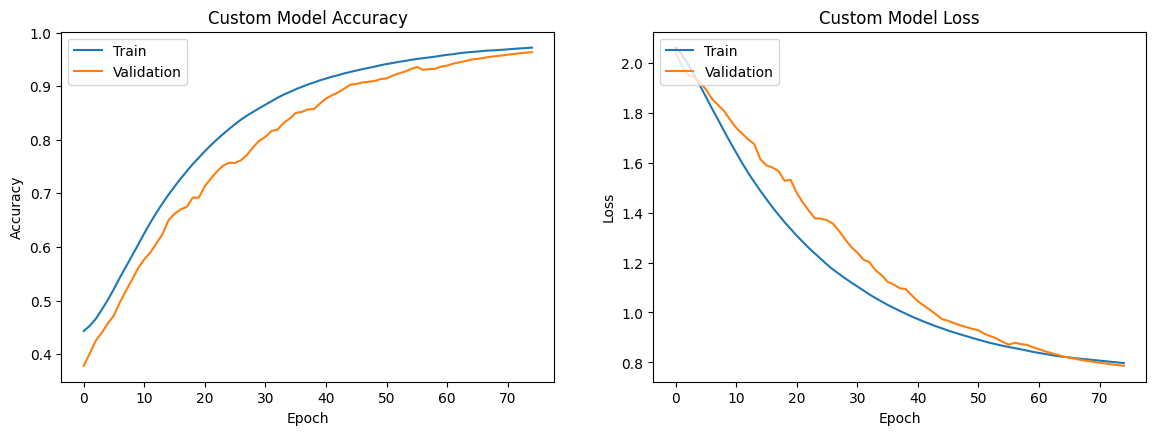

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.subplot(2, 2, 1)
plt.plot((custom_history.history['accuracy']))
plt.plot((custom_history.history['val_accuracy']))
plt.title('Custom Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot((custom_history.history['loss']))
plt.plot((custom_history.history['val_loss']))
plt.title('Custom Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:

print("Training modified ResNet model...")
resnet_model = build_modified_resnet(num_classes)
resnet_model, resnet_history = train_model(resnet_model, "resnet_brain_tumor_model", train_generator, validation_generator)


Training modified ResNet model...
Epoch 1/80
304/304 ━━━━━━━━━━━━━━━━━━━━ 114s 278ms/step - accuracy: 0.4508 - loss: 1.7307 - val_accuracy: 0.6065 - val_loss: 1.2271
Epoch 2/80
304/304 ━━━━━━━━━━━━━━━━━━━━ 69s 227ms/step - accuracy: 0.6009 - loss: 1.2900 - val_accuracy: 0.7555 - val_loss: 1.1581
Epoch 3/80
304/304 ━━━━━━━━━━━━━━━━━━━━ 66s 218ms/step - accuracy: 0.6746 - loss: 1.1910 - val_accuracy: 0.6554 - val_loss: 1.2377
Epoch 4/80
304/304 ━━━━━━━━━━━━━━━━━━━━ 69s 226ms/step - accuracy: 0.7193 - loss: 1.0911 - val_accuracy: 0.8265 - val_loss: 1.0769
Epoch 5/80
304/304 ━━━━━━━━━━━━━━━━━━━━ 68s 224ms/step - accuracy: 0.7647 - loss: 1.0184 - val_accuracy: 0.8033 - val_loss: 1.0037
Epoch 6/80
304/304 ━━━━━━━━━━━━━━━━━━━━ 68s 224ms/step - accuracy: 0.7551 - loss: 1.0140 - val_accuracy: 0.7800 - val_loss: 1.2206
Epoch 7/80
304/304 ━━━━━━━━━━━━━━━━━━━━ 67s 221ms/step - accuracy: 0.7818 - loss: 1.0067 - val_accuracy: 0.8009 - val_loss: 0.9481
Epoch 8/80
304/304 ━━━━━━━━━━━━━━━━━━━━ 69s 226m

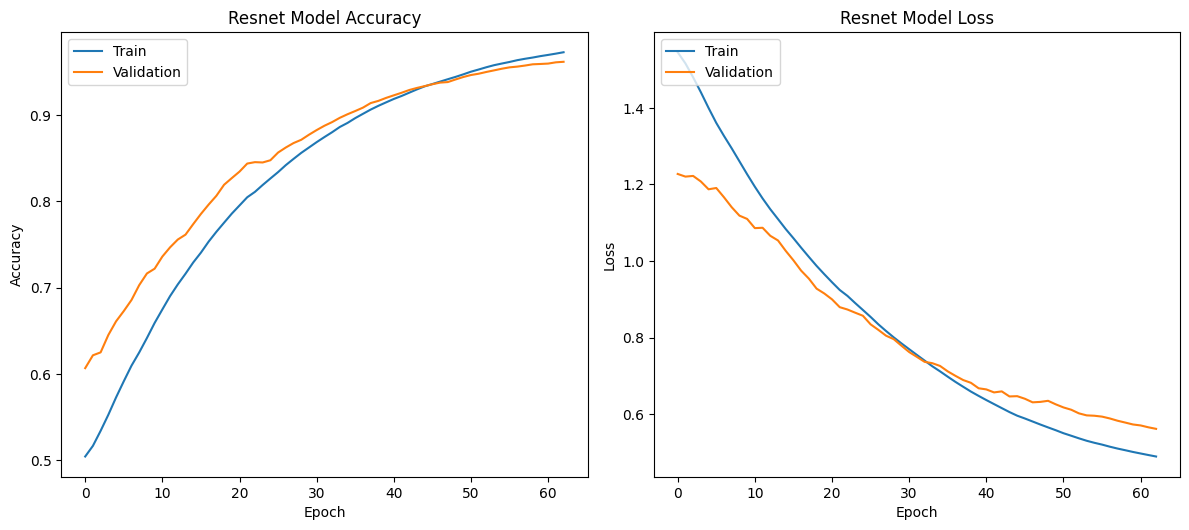

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.subplot(2, 2, 1)
plt.plot((resnet_history.history['accuracy']))
plt.plot((resnet_history.history['val_accuracy']))
plt.title('Resnet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot((resnet_history.history['loss']))
plt.plot((resnet_history.history['val_loss']))
plt.title('Resnet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.tight_layout()
plt.show()


--- Evaluating Model: custom_brain_tumor_model ---
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
Accuracy: 0.9756
Cohen's Kappa: 0.9672
Matthews Corr Coef: 0.9674
Macro Precision: 0.9759
Macro Recall: 0.9741
Macro F1-Score: 0.9748

Classification Report:
              precision    recall  f1-score   support

      glioma     0.9864    0.9700    0.9782       300
  meningioma     0.9761    0.9346    0.9549       306
     notumor     0.9734    0.9951    0.9841       405
   pituitary     0.9676    0.9967    0.9819       300

    accuracy                         0.9756      1311
   macro avg     0.9759    0.9741    0.9748      1311
weighted avg     0.9757    0.9756    0.9754      1311


Confusion Matrix:
[[291   6   0   3]
 [  2 286  11   7]
 [  2   0 403   0]
 [  0   1   0 299]]


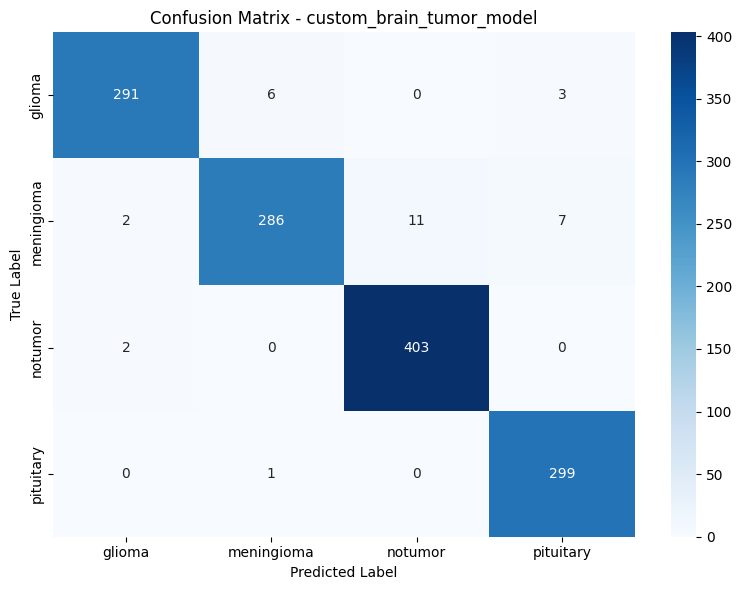

<ipython-input-46-249ee2b4ebc6>:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


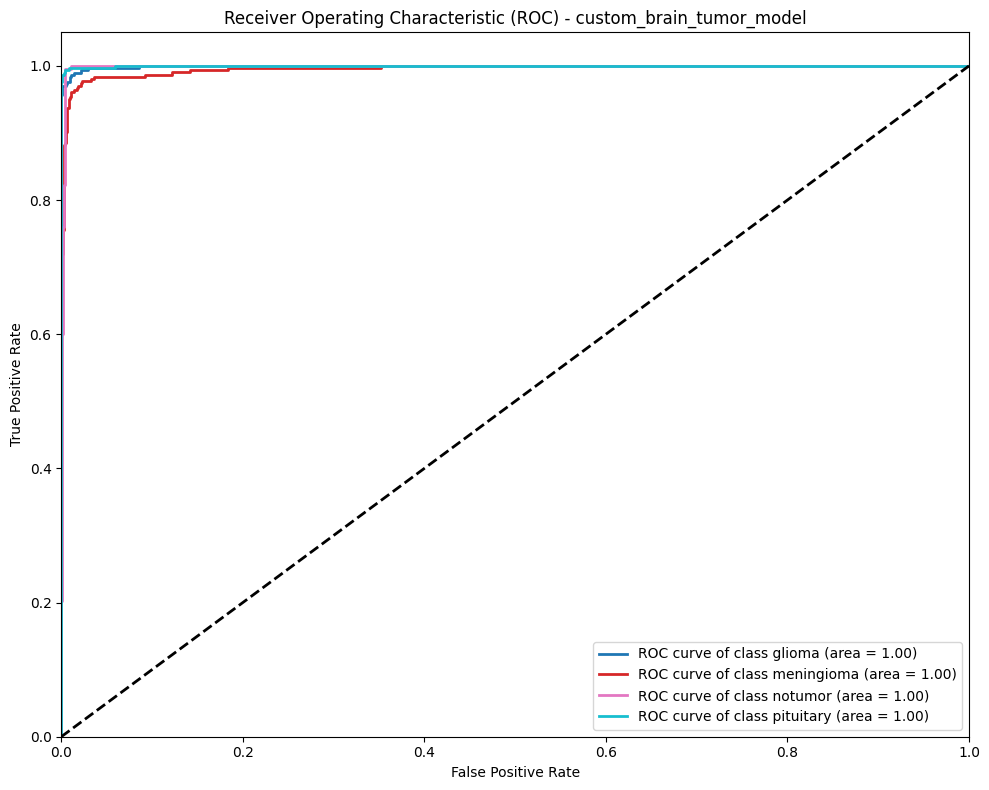

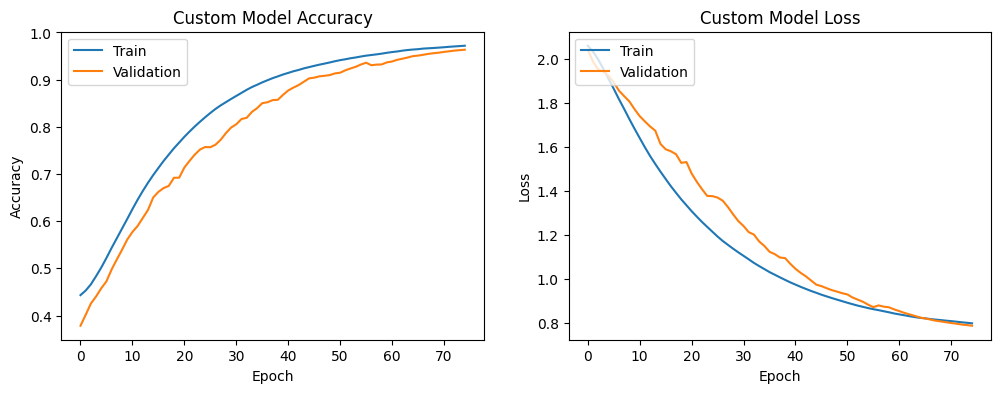

Total Inference Time: 4.38 seconds
Avg Inference Time per Image: 3.3390 ms
Number of Parameters: 1113814
Model Size on Disk: 13.15 MB

--- Evaluating Model: resnet_brain_tumor_model ---
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step
Accuracy: 0.9725
Cohen's Kappa: 0.9631
Matthews Corr Coef: 0.9633
Macro Precision: 0.9733
Macro Recall: 0.9705
Macro F1-Score: 0.9716

Classification Report:
              precision    recall  f1-score   support

      glioma     0.9965    0.9500    0.9727       300
  meningioma     0.9662    0.9346    0.9502       306
     notumor     0.9688    0.9975    0.9830       405
   pituitary     0.9615    1.0000    0.9804       300

    accuracy                         0.9725      1311
   macro avg     0.9733    0.9705    0.9716      1311
weighted avg     0.9729    0.9725    0.9724      1311


Confusion Matrix:
[[285   9   3   3]
 [  1 286  10   9]
 [  0   1 404   0]
 [  0   0   0 300]]


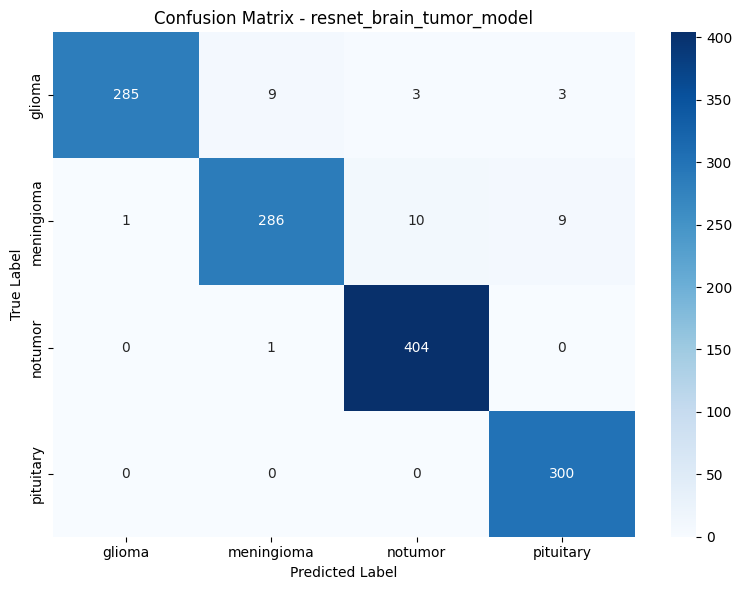

<ipython-input-46-249ee2b4ebc6>:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


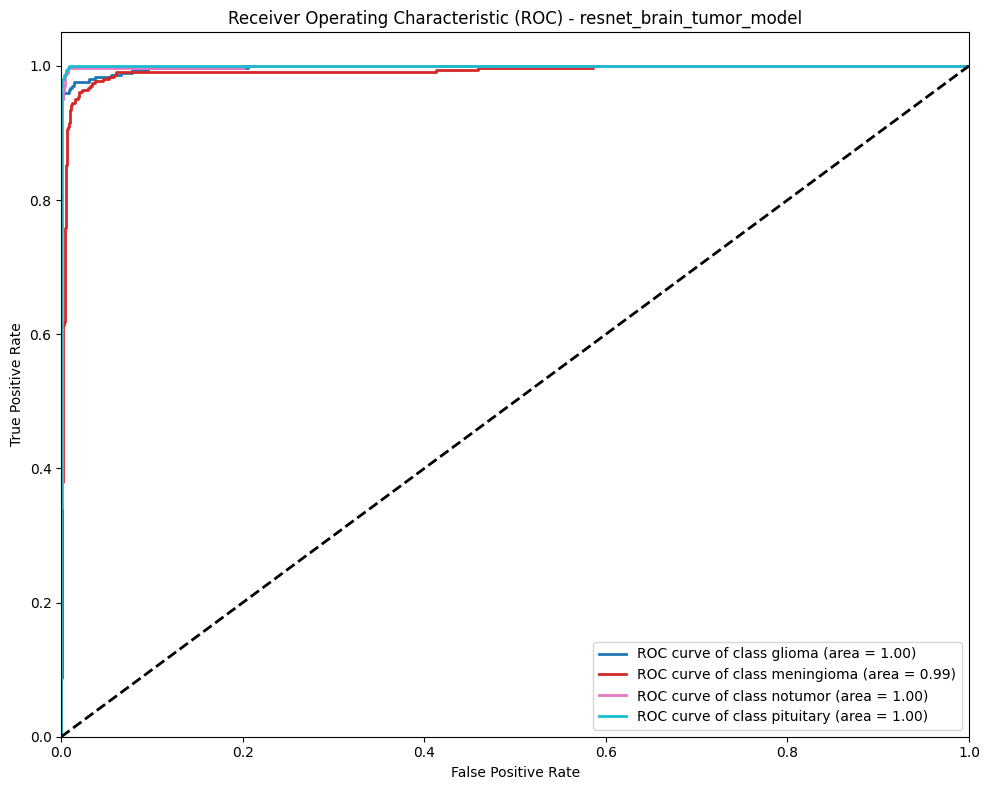

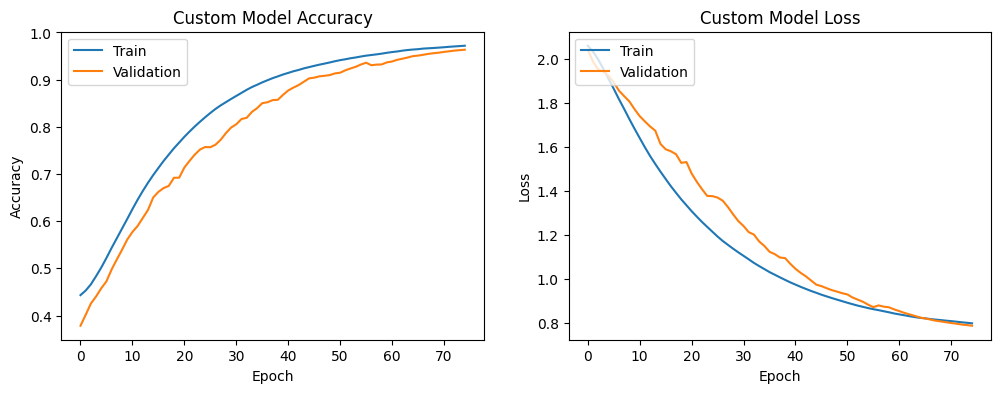

Total Inference Time: 4.67 seconds
Avg Inference Time per Image: 3.5637 ms
Number of Parameters: 24114308
Model Size on Disk: 253.66 MB


--- Benchmark Summary ---
                 model_name  accuracy  macro_f1  weighted_f1     kappa       mcc  inference_time_avg_ms  parameters  disk_size_mb
0  custom_brain_tumor_model  0.975591  0.974785     0.975442  0.967230  0.967365               3.338959     1113814     13.153091
1  resnet_brain_tumor_model  0.972540  0.971556     0.972372  0.963124  0.963345               3.563704    24114308    253.658962


In [ ]:

import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, cohen_kappa_score, matthews_corrcoef, precision_recall_fscore_support
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math


def evaluate_and_report(model, model_name, test_generator, history=None):
    print(f"\n--- Evaluating Model: {model_name} ---")

    start_time = time.time()
    steps = math.ceil(test_generator.samples / test_generator.batch_size)
    y_pred_proba = model.predict(test_generator, steps=steps, verbose=1)
    end_time = time.time()

    y_pred = np.argmax(y_pred_proba, axis=1)

    y_true = test_generator.classes

    if len(y_true) != len(y_pred):
         print(f"Warning: Length mismatch! y_true: {len(y_true)}, y_pred: {len(y_pred)}. Adjusting y_true.")
         y_true = y_true[:len(y_pred)]

    class_labels = list(test_generator.class_indices.keys())
    num_classes = len(class_labels)

    # Calculate Metrics
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=np.arange(num_classes))
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')


    print(f"Accuracy: {accuracy:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Matthews Corr Coef: {mcc:.4f}")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall: {macro_recall:.4f}")
    print(f"Macro F1-Score: {macro_f1:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)


    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/{model_name}_confusion_matrix.png')
    plt.show()

    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_true)
    if num_classes == 2:
         y_true_bin = np.hstack((1-y_true_bin, y_true_bin))
         y_pred_proba_roc = np.hstack((1-y_pred_proba, y_pred_proba))
    else:
         y_pred_proba_roc = y_pred_proba

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba_roc[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = plt.cm.get_cmap('tab10', num_classes)
    for i, color in zip(range(num_classes), colors(range(num_classes))):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_labels[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {model_name}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/{model_name}_roc_curve.png')
    plt.show()

    if history:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot((custom_history.history['accuracy']))
        plt.plot((custom_history.history['val_accuracy']))
        plt.title('Custom Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.subplot(1, 2, 2)
        plt.plot((custom_history.history['loss']))
        plt.plot((custom_history.history['val_loss']))
        plt.title('Custom Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')



    plt.show()

    inference_time = end_time - start_time
    avg_inference_time_per_image = inference_time / test_generator.samples
    model_params = model.count_params()
    try:
        model_size_mb = os.path.getsize(f'/content/drive/MyDrive/best_{model_name}.keras') / (1024 * 1024)
    except FileNotFoundError:
         model_size_mb = -1
         print(f"Warning: Could not find file best_{model_name}.keras to get size.")


    print(f"Total Inference Time: {inference_time:.2f} seconds")
    print(f"Avg Inference Time per Image: {avg_inference_time_per_image*1000:.4f} ms")
    print(f"Number of Parameters: {model_params}")
    print(f"Model Size on Disk: {model_size_mb:.2f} MB")

    metrics = {
        'model_name': model_name,
        'accuracy': accuracy,
        'kappa': kappa,
        'mcc': mcc,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'weighted_precision': weighted_precision,
        'weighted_recall': weighted_recall,
        'weighted_f1': weighted_f1,
        'inference_time_total_s': inference_time,
        'inference_time_avg_ms': avg_inference_time_per_image * 1000,
        'parameters': model_params,
        'disk_size_mb': model_size_mb,
        'class_report': class_report,
        'confusion_matrix': conf_matrix.tolist() # Convert to list for potential saving
    }
    # Add per-class AUC
    for i, label in enumerate(class_labels):
        metrics[f'auc_{label}'] = roc_auc[i]

    return metrics


all_metrics = []

metrics_custom = evaluate_and_report(custom_model, "custom_brain_tumor_model", test_generator, custom_history)
all_metrics.append(metrics_custom)

metrics_resnet = evaluate_and_report(resnet_model, "resnet_brain_tumor_model", test_generator, resnet_history)
all_metrics.append(metrics_resnet)


metrics_df = pd.DataFrame(all_metrics)
cols_to_show = ['model_name', 'accuracy', 'macro_f1', 'weighted_f1', 'kappa', 'mcc', 'inference_time_avg_ms', 'parameters', 'disk_size_mb']
print("\n\n--- Benchmark Summary ---")
print(metrics_df[cols_to_show].to_string())

metrics_df.to_csv('/content/drive/MyDrive/benchmark_results.csv', index=False)



--- Evaluating Ensemble: custom_brain_tumor_model, resnet_brain_tumor_model (Average Prediction) ---
Accuracy: 0.9855
Cohen's Kappa: 0.9805

Classification Report:
              precision    recall  f1-score   support

      glioma     1.0000    0.9700    0.9848       300
  meningioma     0.9739    0.9739    0.9739       306
     notumor     0.9854    0.9975    0.9914       405
   pituitary     0.9836    0.9967    0.9901       300

    accuracy                         0.9855      1311
   macro avg     0.9857    0.9845    0.9850      1311
weighted avg     0.9856    0.9855    0.9855      1311



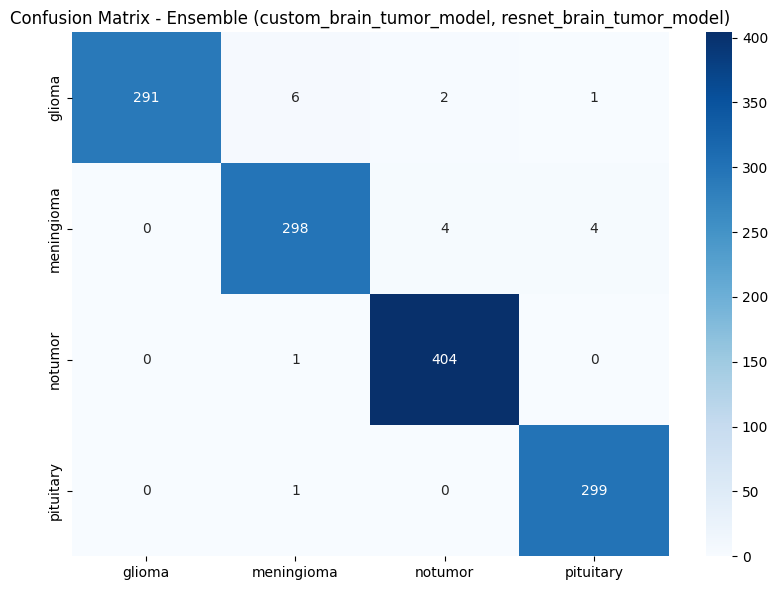

Total Ensemble Inference Time (Sequential): 8.99 seconds
Avg Ensemble Inference Time per Image (Sequential): 6.8558 ms
Total Parameters (Sum of models): 25228122
Max Model Size on Disk (Individual): 253.66 MB (or sum if deployed together)


--- FINAL Benchmark Summary (including Ensemble) ---
                                                      model_name  accuracy  macro_f1  weighted_f1     kappa       mcc  inference_time_avg_ms  parameters  disk_size_mb
0                                       custom_brain_tumor_model  0.975591  0.974785     0.975442  0.967230  0.967365               3.431034     1113814     13.153091
1                                       resnet_brain_tumor_model  0.972540  0.971556     0.972372  0.963124  0.963345               3.659248    24114308    253.658962
2  Ensemble (custom_brain_tumor_model, resnet_brain_tumor_model)  0.985507  0.985026     0.985487  0.980548  0.980595               6.855779    25228122    253.658962


In [ ]:

def evaluate_ensemble(models, model_names, test_generator):
    print(f"\n--- Evaluating Ensemble: {', '.join(model_names)} (Average Prediction) ---")

    all_pred_probas = []
    inference_times = []
    total_params = 0
    max_disk_size = 0

    for model, name in zip(models, model_names):
        start_time = time.time()
        steps = math.ceil(test_generator.samples / test_generator.batch_size)
        pred_proba = model.predict(test_generator, steps=steps, verbose=0)
        end_time = time.time()

        all_pred_probas.append(pred_proba)
        inference_times.append(end_time - start_time)
        total_params += model.count_params()
        try:
            disk_size = os.path.getsize(f'/content/drive/MyDrive/best_{name}.keras') / (1024 * 1024)
            max_disk_size = max(max_disk_size, disk_size)
        except FileNotFoundError:
             print(f"Warning: Could not find file best_{name}.keras to get size.")

    avg_pred_proba = np.mean(np.array(all_pred_probas), axis=0)

    y_pred = np.argmax(avg_pred_proba, axis=1)
    y_true = test_generator.classes

    if len(y_true) != len(y_pred):
        print(f"Warning: Length mismatch! y_true: {len(y_true)}, y_pred: {len(y_pred)}. Adjusting y_true.")
        y_true = y_true[:len(y_pred)]

    class_labels = list(test_generator.class_indices.keys())
    num_classes = len(class_labels)

    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=np.arange(num_classes))
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    print("\nClassification Report:")
    print(class_report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - Ensemble ({", ".join(model_names)})')

    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/ensemble_confusion_matrix.png')
    plt.show()


    total_inference_time = sum(inference_times)
    avg_inference_time_per_image = total_inference_time / test_generator.samples

    print(f"Total Ensemble Inference Time (Sequential): {total_inference_time:.2f} seconds")
    print(f"Avg Ensemble Inference Time per Image (Sequential): {avg_inference_time_per_image*1000:.4f} ms")
    print(f"Total Parameters (Sum of models): {total_params}")
    print(f"Max Model Size on Disk (Individual): {max_disk_size:.2f} MB (or sum if deployed together)")


    ensemble_metrics = {
        'model_name': f"Ensemble ({', '.join(model_names)})",
        'accuracy': accuracy,
        'kappa': kappa,
         'macro_f1': macro_f1,
         'weighted_f1': weighted_f1,
         'mcc': mcc,
        'inference_time_total_s': total_inference_time,
        'inference_time_avg_ms': avg_inference_time_per_image * 1000,
        'parameters': total_params,
        'disk_size_mb': max_disk_size,
        'class_report': class_report,
        'confusion_matrix': conf_matrix.tolist()
    }


    return ensemble_metrics

ensemble_models = [custom_model, resnet_model]
ensemble_names = ["custom_brain_tumor_model", "resnet_brain_tumor_model"]
metrics_ensemble = evaluate_ensemble(ensemble_models, ensemble_names, test_generator)
all_metrics.append(metrics_ensemble)

metrics_df = pd.DataFrame(all_metrics)
print("\n\n--- FINAL Benchmark Summary (including Ensemble) ---")
print(metrics_df[cols_to_show].to_string())


metrics_df.to_csv('/content/drive/MyDrive/benchmark_results_final.csv', index=False)



In [ ]:

import tensorflow as tf
import os
import traceback

print("--- Starting Step 5: Converting Keras Classification Models to TFLite ---")
print(f"Using TensorFlow version for conversion: {tf.__version__}")


drive_tflite_save_dir = '/content/drive/MyDrive/models_tf212/'
os.makedirs(drive_tflite_save_dir, exist_ok=True)


custom_tflite_filename = 'custom_v7223v2.tflite'
resnet_tflite_filename = 'resnet_c7223v2.tflite'

custom_tflite_save_path = os.path.join(drive_tflite_save_dir, custom_tflite_filename)
resnet_tflite_save_path = os.path.join(drive_tflite_save_dir, resnet_tflite_filename)


print(f"\nAttempting to convert 'custom_model' to TFLite...")
try:

    if 'custom_model' not in locals() and 'custom_model' not in globals():
         raise NameError("'custom_model' variable not found. Was training successful?")

    converter_custom = tf.lite.TFLiteConverter.from_keras_model(custom_model)


    print("INFO: Converting as Float32 (no optimizations).")


    tflite_custom_model = converter_custom.convert()
    print("INFO: Conversion successful.")


    print(f"Attempting to save TFLite model to: {custom_tflite_save_path}")
    with open(custom_tflite_save_path, 'wb') as f:
        f.write(tflite_custom_model)
    print(f"✅ SUCCESS: Custom Float32 TFLite model saved.")

except Exception as e:
    print(f"❌ ERROR converting or saving custom_model to TFLite: {e}")
    traceback.print_exc()


print(f"\nAttempting to convert 'resnet_model' to TFLite...")
try:
    if 'resnet_model' not in locals() and 'resnet_model' not in globals():
         raise NameError("'resnet_model' variable not found. Was training successful?")

    converter_resnet = tf.lite.TFLiteConverter.from_keras_model(resnet_model)

    print("INFO: Converting as Float32 (no optimizations).")

    tflite_resnet_model = converter_resnet.convert()
    print("INFO: Conversion successful.")

    print(f"Attempting to save TFLite model to: {resnet_tflite_save_path}")
    with open(resnet_tflite_save_path, 'wb') as f:
        f.write(tflite_resnet_model)
    print(f"✅ SUCCESS: ResNet Float32 TFLite model saved.")

except Exception as e:
    print(f"❌ ERROR converting or saving resnet_model to TFLite: {e}")
    traceback.print_exc()


print("\n--- Finished Step 5 ---")
print("-" * 50)

--- Starting Step 5: Converting Keras Classification Models to TFLite ---
Using TensorFlow version for conversion: 2.18.0

Attempting to convert 'custom_model' to TFLite...
INFO: Converting as Float32 (no optimizations).
Saved artifact at '/tmp/tmp7a16qax4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138662775106320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138665120596240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138662775109200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138662775110160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138662775107856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138662775108624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138662775105936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138

Found 1311 images belonging to 4 classes.
TFLite model accuracy on test set: 0.9725
Cohen's Kappa: 0.9631
Matthews Correlation Coefficient: 0.9633


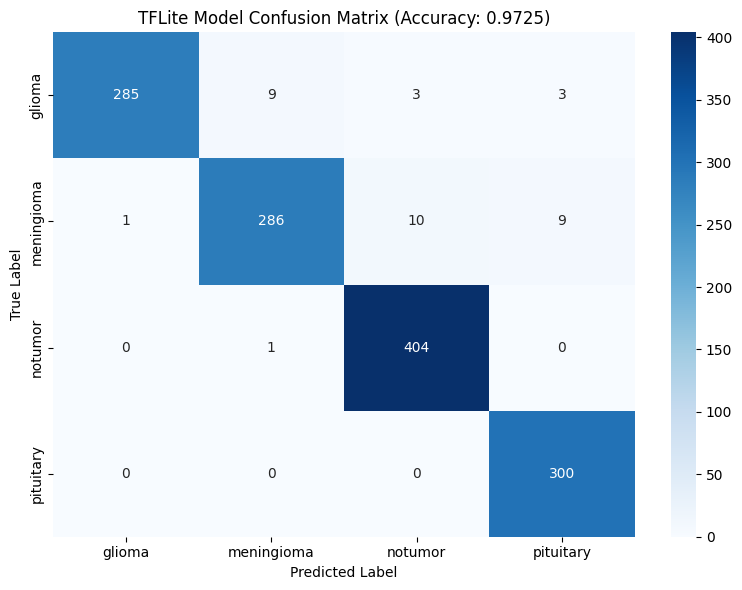

TFLite Model Test Accuracy: 0.9725

Treatment Details for First 10 Predictions:

Sample 1:
Predicted Tumor Type: glioma
Description: Gliomas are tumors that start in glial cells of the brain or spinal cord.
Grade: Varies (I-IV); higher grade is more aggressive.
Typical Symptoms: ['Headaches', 'Seizures', 'Weakness', 'Cognitive changes']
Diagnostic Tests: ['MRI', 'CT Scan', 'Biopsy']
Treatment Options: ['Surgery', 'Radiation therapy', 'Chemotherapy', 'Targeted therapy', 'Clinical trials']
Prognosis: Highly variable depending on grade, type, and location.
Next Steps: Consult neuro-oncologist. Discuss treatment options, side effects, and prognosis. Consider multidisciplinary team approach.

Sample 2:
Predicted Tumor Type: glioma
Description: Gliomas are tumors that start in glial cells of the brain or spinal cord.
Grade: Varies (I-IV); higher grade is more aggressive.
Typical Symptoms: ['Headaches', 'Seizures', 'Weakness', 'Cognitive changes']
Diagnostic Tests: ['MRI', 'CT Scan', 'Biopsy'

In [ ]:


import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
import json

IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 16

tflite_model_path = '/content/drive/MyDrive/models_tf212/resnet_c7223v2.tflite'

testing_dir = '/content/drive/MyDrive/brain_tumor_data_final/Testing'


classes = ['glioma', 'meningioma', 'notumor', 'pituitary']


with open('/content/drive/MyDrive/treatment.json', 'r') as f:
    treatment_data = json.load(f)

valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = valid_test_datagen.flow_from_directory(
    testing_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()


input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


true_labels = []
predicted_labels = []


def evaluate_tflite_model(interpreter, test_generator):
    test_generator.reset()
    num_correct = 0
    total_samples = 0
    all_true_labels = []
    all_predicted_labels = []

    for i in range(len(test_generator)):
        images, labels = next(test_generator)

        for j in range(images.shape[0]):
            img = np.expand_dims(images[j], axis=0).astype(np.float32)

            interpreter.set_tensor(input_details[0]['index'], img)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])

            predicted_class = np.argmax(output_data)
            true_class = np.argmax(labels[j])

            all_true_labels.append(true_class)
            all_predicted_labels.append(predicted_class)

            if predicted_class == true_class:
                num_correct += 1
            total_samples += 1

    accuracy = num_correct / total_samples
    print(f"TFLite model accuracy on test set: {accuracy:.4f}")

    return accuracy, all_true_labels, all_predicted_labels

accuracy, all_true_labels, all_predicted_labels = evaluate_tflite_model(interpreter, test_generator)


kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)
print(f"Cohen's Kappa: {kappa:.4f}")

mcc = matthews_corrcoef(all_true_labels, all_predicted_labels)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

cm = confusion_matrix(all_true_labels, all_predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title(f'TFLite Model Confusion Matrix (Accuracy: {accuracy:.4f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/tflite_confusion_matrix_version3.1.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"TFLite Model Test Accuracy: {accuracy:.4f}")

def output_treatment_details(predicted_label, treatment_data):
    tumor_type = classes[predicted_label]
    details = treatment_data[tumor_type]
    print(f"Predicted Tumor Type: {tumor_type}")
    for key, value in details.items():
        print(f"{key.replace('_', ' ').title()}: {value}")


num_samples_to_output = min(10, len(all_predicted_labels))
print("\nTreatment Details for First {} Predictions:".format(num_samples_to_output))
for i in range(num_samples_to_output):
    print("\nSample {}:".format(i + 1))
    output_treatment_details(all_predicted_labels[i], treatment_data)


Found 1311 images belonging to 4 classes.
TFLite model accuracy on test set: 0.9756
Cohen's Kappa: 0.9672
Matthews Correlation Coefficient: 0.9674


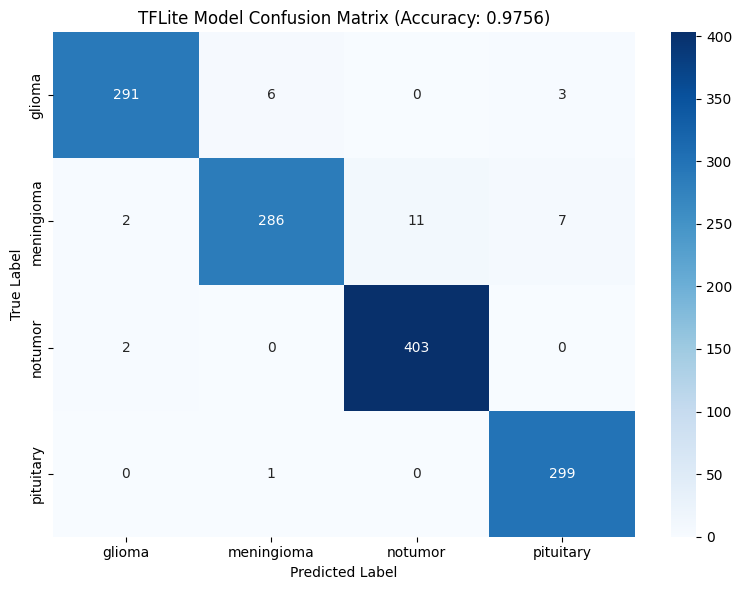

TFLite Model Test Accuracy: 0.9756

Treatment Details for First 10 Predictions:

Sample 1:
Predicted Tumor Type: glioma
Description: Gliomas are tumors that start in glial cells of the brain or spinal cord.
Grade: Varies (I-IV); higher grade is more aggressive.
Typical Symptoms: ['Headaches', 'Seizures', 'Weakness', 'Cognitive changes']
Diagnostic Tests: ['MRI', 'CT Scan', 'Biopsy']
Treatment Options: ['Surgery', 'Radiation therapy', 'Chemotherapy', 'Targeted therapy', 'Clinical trials']
Prognosis: Highly variable depending on grade, type, and location.
Next Steps: Consult neuro-oncologist. Discuss treatment options, side effects, and prognosis. Consider multidisciplinary team approach.

Sample 2:
Predicted Tumor Type: glioma
Description: Gliomas are tumors that start in glial cells of the brain or spinal cord.
Grade: Varies (I-IV); higher grade is more aggressive.
Typical Symptoms: ['Headaches', 'Seizures', 'Weakness', 'Cognitive changes']
Diagnostic Tests: ['MRI', 'CT Scan', 'Biopsy'

In [ ]:


import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
import json


IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 16


tflite_model_path = '/content/drive/MyDrive/models_tf212/custom_v7223v2.tflite'


testing_dir = '/content/drive/MyDrive/brain_tumor_data_final/Testing'

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']


with open('/content/drive/MyDrive/treatment.json', 'r') as f:
    treatment_data = json.load(f)


valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


test_generator = valid_test_datagen.flow_from_directory(
    testing_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()


input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

true_labels = []
predicted_labels = []


def evaluate_tflite_model(interpreter, test_generator):
    test_generator.reset()
    num_correct = 0
    total_samples = 0
    all_true_labels = []
    all_predicted_labels = []

    for i in range(len(test_generator)):
        images, labels = next(test_generator)

        for j in range(images.shape[0]):
            img = np.expand_dims(images[j], axis=0).astype(np.float32)

            interpreter.set_tensor(input_details[0]['index'], img)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])

            predicted_class = np.argmax(output_data)
            true_class = np.argmax(labels[j])

            all_true_labels.append(true_class)
            all_predicted_labels.append(predicted_class)

            if predicted_class == true_class:
                num_correct += 1
            total_samples += 1

    accuracy = num_correct / total_samples
    print(f"TFLite model accuracy on test set: {accuracy:.4f}")

    return accuracy, all_true_labels, all_predicted_labels


accuracy, all_true_labels, all_predicted_labels = evaluate_tflite_model(interpreter, test_generator)


kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)
print(f"Cohen's Kappa: {kappa:.4f}")

mcc = matthews_corrcoef(all_true_labels, all_predicted_labels)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")


cm = confusion_matrix(all_true_labels, all_predicted_labels)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title(f'TFLite Model Confusion Matrix (Accuracy: {accuracy:.4f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/tflite_confusion_matrix_version3.1.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"TFLite Model Test Accuracy: {accuracy:.4f}")


def output_treatment_details(predicted_label, treatment_data):
    tumor_type = classes[predicted_label]
    details = treatment_data[tumor_type]
    print(f"Predicted Tumor Type: {tumor_type}")
    for key, value in details.items():
        print(f"{key.replace('_', ' ').title()}: {value}")

num_samples_to_output = min(10, len(all_predicted_labels))
print("\nTreatment Details for First {} Predictions:".format(num_samples_to_output))
for i in range(num_samples_to_output):
    print("\nSample {}:".format(i + 1))
    output_treatment_details(all_predicted_labels[i], treatment_data)


In [ ]:


import os
import tensorflow as tf


custom_model_path = '/content/drive/MyDrive/custom_brain_tumor_model_versionfinal.keras'
resnet_model_path = '/content/drive/MyDrive/resnet_brain_tumor_model_versionfinal.keras'


custom_model.save(custom_model_path)
print(f"Custom CNN model saved to {custom_model_path}")

resnet_model.save(resnet_model_path)
print(f"ResNet model saved to {resnet_model_path}")


Custom CNN model saved to /content/drive/MyDrive/custom_brain_tumor_model_versionfinal.keras
ResNet model saved to /content/drive/MyDrive/resnet_brain_tumor_model_versionfinal.keras
